In [12]:
from Bio.Cluster import kcluster
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
import shutil
import glob
import time
import os
import re

### Analysis input
input="TEVp-240412"
input_dataframe=pd.read_csv(f"output/{input}/opt_binders/metrics.csv")

os.makedirs(f"output/{input}/filtered_sequences/filtered_binders", exist_ok=True)
input_dataframe.describe()

,index,score,plddt,i_ptm,i_pae,i_con,rmsd,ddg,rg,charge,...,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int
count,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,...,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000
mean,20730.784981,0.781755,0.938457,0.866248,5.342490,1.845904,0.523360,-36.828335,10.774470,-6.741554,...,-36.506914,-2.310745,-2.290091,460.606473,14.728525,15.311453,-0.582928,26.897083,25.456510,1.440573
std,5977.640437,0.077664,0.013806,0.039462,0.714348,0.223751,0.286074,6.310117,0.472407,2.573272,...,7.521451,0.427492,0.490340,49.241533,2.110061,2.120390,1.146172,3.402631,2.962638,1.335244
min,252.000000,0.591597,0.900507,0.702869,4.312702,1.505569,0.084669,-55.070000,9.430258,-15.743439,...,-58.446910,-3.639900,-3.421600,245.151505,8.000000,8.000000,-5.000000,16.000000,16.000000,-1.000000
25%,18340.250000,0.726310,0.929360,0.854787,4.889615,1.684154,0.303449,-41.249000,10.713017,-8.713919,...,-41.341655,-2.613047,-2.606185,427.389870,13.000000,14.000000,-1.000000,25.000000,23.000000,0.000000
50%,21869.500000,0.775498,0.941194,0.880335,5.089870,1.773402,0.450813,-37.157000,10.850237,-6.744180,...,-37.526165,-2.331916,-2.351262,459.188400,15.000000,15.000000,0.000000,27.000000,25.000000,1.000000
75%,25165.250000,0.828295,0.949764,0.891588,5.587489,1.980883,0.690192,-32.342000,11.019417,-4.763386,...,-33.043962,-2.024247,-2.071960,495.677933,16.000000,17.000000,0.000000,29.000000,27.000000,2.000000
max,28732.000000,1.071248,0.964927,0.916043,7.968145,2.557974,1.499074,-13.972000,11.568252,2.223444,...,-1.001620,-0.797203,-0.062302,607.977417,23.000000,22.000000,4.000000,42.000000,40.000000,9.000000


## Filter dataframe
tipical metrics:
- plddt > 0.85-0.9
- i_pae < 5
- ddg_dsasa_100 < -2.5 - -3.5 (sort by)
additional metrics:
- charge < -2
- hyd_contacts > 4-6
- sap < 30-60

In [13]:
filtered = input_dataframe[(input_dataframe["plddt"]>0.90)&
                           (input_dataframe["i_pae"]<7)&
                           (input_dataframe["ddg"]<-30)&
                           (input_dataframe["charge"]<-2)&
                           (input_dataframe["ddg_dsasa_100"]<-2)&
                           #(input_dataframe["ddgscore_dsasa_100"]<-2.5)&
                           (input_dataframe["shape_comp"]>0.5)&
                           (input_dataframe["vbuns_int"]<1)&
                           (input_dataframe["cms"]>400)&
                           (input_dataframe["hyd_contacts"]>4)]
                          # (input_dataframe["sap"]<100)]#&
                           #(input_dataframe["dG"]<30)]

filtered = filtered.sort_values(by='ddg_dsasa_100', ascending=True).drop_duplicates("seq")
filtered.to_csv(f"output/{input}/filtered_sequences/0_filtered_binders.csv", index=False)
filtered.reset_index(inplace=True)
filtered

,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,...,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int
0,828,25598,0.786517,0.950615,0.886767,5.086625,1.653931,0.582082,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-40.610708,-3.497042,-2.641594,450.348022,16.0,16.0,0.0,27.0,26.0,1.0
1,864,25844,0.775034,0.946755,0.885805,5.184576,1.669302,0.579704,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-43.562858,-3.463431,-2.918204,490.056335,17.0,18.0,-1.0,27.0,25.0,2.0
2,904,25842,0.742625,0.944248,0.879772,5.239617,1.690142,0.565556,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-41.661551,-3.426207,-2.833289,493.748993,16.0,16.0,0.0,30.0,27.0,3.0
3,895,25602,0.734574,0.944781,0.870437,5.413421,1.729809,0.705146,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-42.324580,-3.413963,-2.994581,428.840363,15.0,15.0,0.0,28.0,26.0,2.0
4,941,25599,0.761083,0.942069,0.870414,5.423816,1.746343,0.598082,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-42.756509,-3.407463,-2.986761,478.126740,14.0,14.0,0.0,32.0,30.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,695,23872,0.708480,0.952300,0.895503,4.798962,1.703290,0.386597,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-43.735469,-2.005069,-2.701310,481.877350,15.0,15.0,0.0,27.0,27.0,0.0
2098,3483,19770,0.745833,0.910298,0.815194,6.368112,2.211138,0.624800,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-16.625236,-2.004068,-0.987408,509.545685,19.0,19.0,0.0,29.0,27.0,2.0
2099,521,16435,0.768776,0.955697,0.910063,4.526600,1.553666,0.781897,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-45.276379,-2.003410,-2.717085,472.561768,15.0,15.0,0.0,27.0,26.0,1.0
2100,615,23851,0.721136,0.955720,0.892465,4.846802,1.689228,0.247075,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-47.067135,-2.001108,-2.820459,487.108978,16.0,16.0,0.0,30.0,29.0,1.0


In [14]:
filtered['rfd_id'] = filtered['input_pdb'].apply(lambda x: x.split(input+"_")[-1].split('.pdb')[0])
filtered['rfd_id']


rfd_id_counts = filtered['rfd_id'].value_counts()

# Get the number of unique 'rfd_id' values
unique_rfd_ids_count = filtered['rfd_id'].nunique()

# Display the counts of each 'rfd_id' and the number of unique 'rfd_id' values
print("Counts of each 'rfd_id':")
print(rfd_id_counts)
print("\nNumber of unique 'rfd_id' values:", unique_rfd_ids_count)

Counts of each 'rfd_id':
rfd_id
lcb3_22_9_49_1_2_4    10
lcb3_22_9_49          10
lcb3_14_7_18_1_3_1     9
lcb3_2_3_44_1_6_1      9
lcb3_21_5_35_1_8_4     8
                      ..
lcb3_14_4_30_1_7_4     1
51_3H_1_0_40_2_9_1     1
27_3H_20_8_3_1_6_0     1
27_3H_16_6_6_2_9_4     1
60_3Hs_29_9_5_0_26     1
Name: count, Length: 902, dtype: int64

Number of unique 'rfd_id' values: 902


In [15]:
# Calculate statistics on scaffolds
scaffold_counts = filtered["scaffold_name"].value_counts()
total_unique_scaffolds = len(scaffold_counts)
total_scaffold_instances = scaffold_counts.sum()

print("Total unique scaffolds:", total_unique_scaffolds)
print("Total scaffold instances:", total_scaffold_instances)
print("\nScaffold counts:")
print(scaffold_counts)

Total unique scaffolds: 20
Total scaffold instances: 2102

Scaffold counts:
scaffold_name
lcb3_30    185
lcb3_16    182
lcb3_21    181
lcb3_2     162
2H3E_18    147
lcb3_14    146
lcb3_15    144
lcb3_9     142
lcb3_27    131
lcb3_17    129
lcb3_7     120
lcb3_22    103
27_3H       94
60_3Hs      76
lcb3_28     55
lcb3_6      41
lcb3_25     39
lcb3_10     11
51_3H       11
lcb3_8       3
Name: count, dtype: int64


In [16]:
def repeat_rows_by_column_value(df, column_name, number):
    unique_values = df[column_name].unique()
    repeated_rows = []

    for value in unique_values:
        subset = df[df[column_name] == value]
        num_repeats = min(number, subset.shape[0])
        repeated_rows.extend([subset.iloc[i, :] for i in range(num_repeats)])

    repeated_df = pd.DataFrame(repeated_rows)
    return repeated_df
filtered=repeat_rows_by_column_value(filtered, "rfd_id", 100)
filtered.to_csv(f"output/{input}/opt_binders/filtered_af2_rf2.csv")
filtered

,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,...,ddg_dsasa_100,ddgscore_dsasa_100,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,rfd_id
0,828,25598,0.786517,0.950615,0.886767,5.086625,1.653931,0.582082,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-3.497042,-2.641594,450.348022,16.0,16.0,0.0,27.0,26.0,1.0,lcb3_30_5_9_1_1_1
43,985,25591,0.720892,0.939800,0.872503,5.424561,1.746528,0.402491,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-3.173926,-2.807723,454.371948,16.0,16.0,0.0,30.0,29.0,1.0,lcb3_30_5_9_1_1_1
1,864,25844,0.775034,0.946755,0.885805,5.184576,1.669302,0.579704,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-3.463431,-2.918204,490.056335,17.0,18.0,-1.0,27.0,25.0,2.0,lcb3_30_5_9_2_4_3
28,887,25814,0.778578,0.945183,0.873484,5.321336,1.728233,0.227877,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-3.224227,-2.671011,456.343201,19.0,20.0,-1.0,31.0,30.0,1.0,lcb3_30_5_9_2_4_3
63,976,25834,0.790076,0.940238,0.874196,5.306765,1.730273,0.460264,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-3.133263,-3.144221,462.556427,18.0,18.0,0.0,31.0,30.0,1.0,lcb3_30_5_9_2_4_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,1101,12699,0.942746,0.936123,0.881130,4.883672,1.746389,0.977960,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-2.019938,-1.938982,446.714325,17.0,17.0,0.0,20.0,19.0,1.0,51_3H_10_2_17_0_23
2081,791,21985,0.708148,0.949772,0.892706,4.863418,1.740892,0.455698,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-2.017277,-2.732778,496.035828,13.0,13.0,0.0,24.0,24.0,0.0,lcb3_2_3_15_0_3
2086,1972,2779,0.779429,0.946106,0.896699,4.986964,1.733326,0.444355,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-2.011895,-2.324974,441.682007,14.0,15.0,-1.0,21.0,19.0,2.0,27_3H_16_6_29_2_6_2
2091,437,17085,0.816915,0.957562,0.909086,4.502870,1.544954,0.459522,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-2.008574,-2.014478,412.305969,14.0,14.0,0.0,25.0,22.0,3.0,60_3Hs_29_9_9_1_2_1


In [17]:
#filtered=repeat_rows_by_column_value(filtered, "scaffold_name", 22)
filtered.to_csv(f"output/{input}/opt_binders/filtered_af2_rf2.csv")
filtered

,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,...,ddg_dsasa_100,ddgscore_dsasa_100,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,rfd_id
0,828,25598,0.786517,0.950615,0.886767,5.086625,1.653931,0.582082,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-3.497042,-2.641594,450.348022,16.0,16.0,0.0,27.0,26.0,1.0,lcb3_30_5_9_1_1_1
43,985,25591,0.720892,0.939800,0.872503,5.424561,1.746528,0.402491,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-3.173926,-2.807723,454.371948,16.0,16.0,0.0,30.0,29.0,1.0,lcb3_30_5_9_1_1_1
1,864,25844,0.775034,0.946755,0.885805,5.184576,1.669302,0.579704,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-3.463431,-2.918204,490.056335,17.0,18.0,-1.0,27.0,25.0,2.0,lcb3_30_5_9_2_4_3
28,887,25814,0.778578,0.945183,0.873484,5.321336,1.728233,0.227877,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-3.224227,-2.671011,456.343201,19.0,20.0,-1.0,31.0,30.0,1.0,lcb3_30_5_9_2_4_3
63,976,25834,0.790076,0.940238,0.874196,5.306765,1.730273,0.460264,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-3.133263,-3.144221,462.556427,18.0,18.0,0.0,31.0,30.0,1.0,lcb3_30_5_9_2_4_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,1101,12699,0.942746,0.936123,0.881130,4.883672,1.746389,0.977960,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-2.019938,-1.938982,446.714325,17.0,17.0,0.0,20.0,19.0,1.0,51_3H_10_2_17_0_23
2081,791,21985,0.708148,0.949772,0.892706,4.863418,1.740892,0.455698,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-2.017277,-2.732778,496.035828,13.0,13.0,0.0,24.0,24.0,0.0,lcb3_2_3_15_0_3
2086,1972,2779,0.779429,0.946106,0.896699,4.986964,1.733326,0.444355,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-2.011895,-2.324974,441.682007,14.0,15.0,-1.0,21.0,19.0,2.0,27_3H_16_6_29_2_6_2
2091,437,17085,0.816915,0.957562,0.909086,4.502870,1.544954,0.459522,output/TEVp-240412/opt_binders/binders/TEVp-24...,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,-2.008574,-2.014478,412.305969,14.0,14.0,0.0,25.0,22.0,3.0,60_3Hs_29_9_9_1_2_1


## Test with ColabFold and Rosettafold2

In [18]:
def generate_fasta_sequence_from_pdb(pdb_file, output_folder=None):
    ca_pattern = re.compile(r"^ATOM\s{2,6}\d{1,5}\s{2}CA\s[\sA]([A-Z]{3})\s([\s\w])|^HETATM\s{0,4}\d{1,5}\s{2}CA\s[\sA](MSE)\s([\s\w])")
    aa3to1={
        'ALA':'A', 'VAL':'V', 'PHE':'F', 'PRO':'P', 'MET':'M',
        'ILE':'I', 'LEU':'L', 'ASP':'D', 'GLU':'E', 'LYS':'K',
        'ARG':'R', 'SER':'S', 'THR':'T', 'TYR':'Y', 'HIS':'H',
        'CYS':'C', 'ASN':'N', 'GLN':'Q', 'TRP':'W', 'GLY':'G',
        'MSE':'M',
    }
    filename = os.path.basename(pdb_file).split('.')[0]
    chain_dict = dict()
    chain_list = []

    with open(pdb_file, 'r') as fp:
        for line in fp:
            if line.startswith("ENDMDL"):
                break
            match_list = ca_pattern.findall(line)
            if match_list:
                resn = match_list[0][0] + match_list[0][2]
                chain = match_list[0][1] + match_list[0][3]
                if chain in chain_dict:
                    chain_dict[chain] += aa3to1[resn]
                else:
                    chain_dict[chain] = aa3to1[resn]
                    chain_list.append(chain)

    fasta_sequence = f">{filename}\n"
    for i, chain in enumerate(chain_list):
        fasta_sequence += chain_dict[chain]
        if i < len(chain_list) - 1:
            fasta_sequence += ':'

    if output_folder:
        output_file = os.path.join(output_folder, f"{filename}.fasta")
        with open(output_file, 'w') as fp:
            fp.write(fasta_sequence)

    return chain_dict

def process_a3m_file_rf2(binder_sequence, sample_a3m_path, processed_file_name, verbose=False):
    if os.path.isfile(sample_a3m_path):
        with open(sample_a3m_path, 'r') as file:
            lines = file.readlines()

        # Replace old_binder_sequence with binder_sequence in the rest of the lines
        if verbose:
            print(lines[1])
        old_binder_sequence = lines[1].strip().split('/')[1]
        if verbose:
            print(old_binder_sequence)
        for i in range(0, len(lines)):
            lines[i] = lines[i].replace(old_binder_sequence, binder_sequence)

            # Check if the line contains "-" and replace it accordingly
            if not lines[i].startswith('>') and lines[i].split('/')[1].startswith("-"):
                lines[i] = lines[i].split('/')[0] + "/" + "-" * len(binder_sequence) + "\n"

        # Save the processed lines to a new file
        new_file_path = f"{processed_file_name}"
        with open(new_file_path, 'w') as new_file:
            new_file.writelines(lines)

def process_a3m_file_af2(binder_sequence, sample_a3m_path, processed_file_name):
    if os.path.isfile(sample_a3m_path):
        with open(sample_a3m_path, 'r') as file:
            lines = file.readlines()

        # Extract the target sequence from the first line
        target_sequence_line = lines[0].strip()
        if target_sequence_line.startswith('#'):
            target_length = int(target_sequence_line[1:].split(',')[0].strip())
            #print(target_length)
        else:
            raise ValueError("The target sequence is not properly specified in the first line.")

        # Change line 0
        lines[0] = f"#{target_length},{len(binder_sequence)}\t1,1\n"
        # Change line 3
        target_sequence = lines[2].strip()[:target_length]
        old_binder_sequence = lines[2].strip()[target_length:]
        lines[2] = target_sequence + binder_sequence + "\n"

        # Replace old_binder_sequence with binder_sequence in the rest of the lines
        for i in range(3, len(lines)):
            lines[i] = lines[i].replace(old_binder_sequence, binder_sequence)

        # Write the processed lines to the output file
        with open(processed_file_name, 'w') as processed_file:
            processed_file.writelines(lines)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1872304/118242410.py:2: SyntaxWarning: invalid escape sequence '\s'
  ca_pattern = re.compile("^ATOM\s{2,6}\d{1,5}\s{2}CA\s[\sA]([A-Z]{3})\s([\s\w])|^HETATM\s{0,4}\d{1,5}\s{2}CA\s[\sA](MSE)\s([\s\w])")


## TEST

In [ ]:
# Create folders for samples
# make from whole sequence
msa_folder_rf2 = f"output/{input}/filtered_sequences/msa_inputs_rf2"
os.makedirs(msa_folder_rf2, exist_ok=True)

sample_msa_folder_rf2 = f"{msa_folder_rf2}/sample"
os.makedirs(sample_msa_folder_rf2, exist_ok=True)

# AF2
msa_folder_af2 = f"output/{input}/filtered_sequences/msa_inputs_af2"
os.makedirs(msa_folder_rf2, exist_ok=True)

sample_msa_folder_af2 = f"{msa_folder_af2}/sample"
os.makedirs(sample_msa_folder_af2, exist_ok=True)

# ?
filtered_binders_path=f"output/{input}/filtered_sequences/filtered_binders" #??
os.makedirs(filtered_binders_path, exist_ok=True)

# copy pdbs to filtered binders
for i,row in filtered.iterrows():
    # Copy pdb in filtered folder
    model_path=row["model_path"]
    model_name=model_path.split("/")[-1]
    new_model_path=f"{filtered_binders_path}/{model_name}"
    shutil.copyfile(model_path, new_model_path)

In [ ]:
filtered["seq"][0].split("/")[0]

In [ ]:
# prepare msa
#BTN3A1
#target_whole_seq="QFSVLGPSGPILAMVGEDADLPCHLFPTMSAETMELKWVSSSLRQVVNVYADGKEVEDRQSAPYRGRTSILRDGITAGKAALRIHNVTASDSGKYLCYFQDGDFYEKALVELKVAALGSDLHVDVKGYKDGGIHLECRSTGWYPQPQIQWSNNKGENIPTVEAPVVADGVGLYAVAASVIMRGSSGEGVSCTIRSSLLGLEKTASISIADPFF"
#ninj_m
#target_whole_seq="FGSPGEPQIIFCRSEAAHQGVITWNPPQRSFHNFTLCYIKETEKDCLNLDKNLIKYDLQNLKPYTKYVLSLHAYIIAKVQRNGSAAMCHFTTKSAPPSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVRNESHKNCDFRVKDLQYSTDYTFKAYFHNGDYPGEPFILHHSTS"
target_whole_seq=filtered["seq"][0].split("/")[0]

sample_a3m_path_rf2 = f"{msa_folder_rf2}/sample/sample.a3m"
sample_a3m_path_af2 = f"{msa_folder_af2}/sample/sample.a3m"


random_binder_seq=filtered["seq"][0].split("/")[-1]
print(f"binder sequence: {random_binder_seq}")
print(f"target sequence: {target_whole_seq}")
# Create fasta
fasta_file_af2=f"{sample_msa_folder_af2}/fasta.fasta"
with open(f"{fasta_file_af2}", "w") as f:
    # Write the sequence to the file in FASTA format
    f.write(f">sample\n{target_whole_seq}:{random_binder_seq}\n")

In [ ]:
### Generate MSA for AF2 and RF2


### AF2
input_pdb=filtered["model_path"][0]
slurm_args="" #"--output=/dev/null"
cmd = f"sbatch {slurm_args} helper_scripts/get_msa_colabfold.sh {input_pdb} {sample_msa_folder_af2}"

# Run the system command to execute the get_msa.py script
#a3m_path_af2 = f"{sample_msa_folder_af2}/{input_pdb.split('/')[-1].split('.')[0]}.a3m"
if not os.path.exists(sample_a3m_path_af2):
    os.system(cmd)

### RF2
cmd_rf2 = f"sbatch {slurm_args} helper_scripts/get_msa_rf.sh {fasta_file_af2} {sample_msa_folder_rf2}"

# Run the system command to execute the get_msa.py script
#sample_a3m_path = f"{sample_msa_folder_rf2}/sample.a3m"
if not os.path.exists(sample_a3m_path_rf2):
    os.system(cmd_rf2)


### WAITING
# Wait until MSA is calculated...
while not os.path.exists(sample_a3m_path_af2):
    time.sleep(1)

print("MSA calculation for AF2 is complete.")

while not os.path.exists(sample_a3m_path_rf2):
    time.sleep(1)
print("MSA calculation for RF2 is complete.")


In [ ]:
### Generate other MSA files for RF2 and copy binders

filtered["new_model_path"]=None
filtered["generated_a3m_rf2"]=None

filtered_binders_path=f"output/{input}/filtered_sequences/filtered_binders"
os.makedirs(filtered_binders_path, exist_ok=True)

binder_chain="B"

for i,row in filtered.iterrows():
    # Copy pdb in filtered folder
    model_path=row["model_path"]
    model_name=model_path.split("/")[-1]
    new_model_path=f"{filtered_binders_path}/{model_name}"
    #shutil.copyfile(model_path, new_model_path)
    binder_seq=row["seq"].split("/")[-1]

    #binder_seq=generate_fasta_sequence_from_pdb(row["model_path"])["B"]
    a3m_file_name=f"{msa_folder_rf2}/{model_name.split('.')[0]}.a3m"
    sample_a3m_path = sample_a3m_path_rf2
    process_a3m_file_rf2(binder_seq, sample_a3m_path, a3m_file_name)

    # Update DataFrame with new values
    filtered.loc[i, "new_model_path"] = new_model_path
    filtered.loc[i, "generated_a3m_rf2"] = a3m_file_name

# Check A3M files generated
msa_a3m_inputs = glob.glob(f"{msa_folder_rf2}/*a3m")
print(f"There is {len(msa_a3m_inputs)} a3m files ready to be predicted with RF2!")

### Generate other MSA files for AF2 and copy binders

filtered["new_model_path"]=None
filtered["generated_a3m_af2"]=None


binder_chain="B"

for i,row in filtered.iterrows():
    # Copy pdb in filtered folder
    model_path=row["model_path"]
    model_name=model_path.split("/")[-1]
    new_model_path=f"{filtered_binders_path}/{model_name}"
    #shutil.copyfile(model_path, new_model_path)

    # Generate msa
    #binder_seq=generate_fasta_sequence_from_pdb(row["model_path"])["B"]
    binder_seq=row["seq"].split("/")[-1]
    a3m_file_name=f"{msa_folder_af2}/{model_name.split('.')[0]}.a3m"
    #sample_a3m_path_af2="/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/5fmv_domain3-4/filtered_sequences/msa_inputs_af2/sample/sample.a3m"
    process_a3m_file_af2(binder_seq, sample_a3m_path_af2, a3m_file_name)

    # Update DataFrame with new values
    filtered.loc[i, "new_model_path"] = new_model_path
    filtered.loc[i, "generated_a3m_af2"] = a3m_file_name

# Check A3M files generated
msa_a3m_inputs = glob.glob(f"{msa_folder_af2}/*a3m")
print(f"There is {len(msa_a3m_inputs)} a3m files ready to be predicted with AF2!")

### Generate RF2 MSA files

### Run prediction

In [ ]:
# Set the prediction options as a dictionary with booleans
prediction_options = {
    "colabfold": True,       # Set to True if you want to run ColabFold
    "rosettafold2": True,    # Set to True if you want to run RosettaFold2 (not currently used)
    "esmfold": False,        # Set to True if you want to run ESMfold (not currently used)
}

array_limit=10
binder_analysis="binder-second" # if you want to perform binder analysis
msa_folder=f"output/{input}/filtered_sequences"

array_number=len(msa_a3m_inputs)
#array_number=300
tools = " ".join([tool for tool, should_run in prediction_options.items() if should_run])
print(tools)
bash_arguments=f"--array=0-{array_number}%{array_limit}"
#bash_arguments=f"--output=/dev/null --array=0-{array_number}%{array_limit}"
script_arguments=f"{msa_folder} {filtered_binders_path} {binder_analysis} {tools} "

command = f"sbatch {bash_arguments} helper_scripts/predict_binders.sh {script_arguments}"
print(command)

In [ ]:
subprocess.run(command, shell=True)

### Append and filter with scores

In [2]:
#af2_dataframe_columns = ['plddt', 'pae', 'binder_plddt', 'target_plddt', 'pae_binder', 'pae_target', 'pae_int_tot', 'rmsd', 'name', 'model_id']
#rf2_dataframe_columns = ['mean_plddt', 'pae_chain0_0', 'rmsd', 'name', 'model_id', 'plddt_target', 'plddt_binder', 'plddt', 'pae']

# Open filtered dataframe
filtered=pd.read_csv(f"output/{input}/opt_binders/filtered_af2_rf2.csv")
#filtered = pd.read_csv(f"output/{input}/filtered_sequences/0_filtered_binders.csv")
filtered["model_id"]=filtered["model_path"].str.split("/").str[-1].str.split(".").str[0]

# Open scores to append
af2_scores=pd.read_csv(f"output/{input}/filtered_sequences/filtered_binders/scores/scores_af2.csv")
#rf2_scores=pd.read_csv(f"output/{input}/filtered_sequences/filtered_binders/scores/scores_rf2.csv")
# Fix old model_ids
af2_scores["model_id"] = af2_scores["model_id"].str.replace(r"-AF2$", "", regex=True)
#rf2_scores["model_id"] = rf2_scores["model_id"].str.replace(r"-RF2$", "", regex=True)

# Columns to append
af2_column_append = ['binder_plddt', 'pae_int_tot', 'rmsd']
#rf2_column_append = ['plddt_binder', 'pae', 'rmsd']

# Prepare columns to add
#rf2_scores = rf2_scores[rf2_column_append + ['model_id']].rename(columns=lambda x: f'rf_{x}' if x != 'model_id' else x)
af2_scores = af2_scores[af2_column_append + ['model_id']].rename(columns=lambda x: f'af_{x}' if x != 'model_id' else x)

# Merge to filtered
filtered = filtered.merge(af2_scores, on='model_id', how='left')
#filtered = filtered.merge(rf2_scores, on='model_id', how='left')
filtered.describe()

,Unnamed: 0,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,ddg,...,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,af_binder_plddt,af_pae_int_tot,af_rmsd
count,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,...,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,847.000000,847.000000,847.000000
mean,929.116959,1890.042105,21042.090058,0.783797,0.939806,0.868998,5.290511,1.831342,0.518511,-40.783592,...,465.858986,14.766082,15.730994,-0.964912,26.631579,25.336842,1.294737,86.797737,10.537441,2.502183
std,633.493075,1122.901765,5783.330671,0.080623,0.013475,0.030753,0.587397,0.196995,0.268688,4.821699,...,40.610001,2.048366,2.093854,1.099791,2.953771,2.692036,1.108687,5.039714,2.460775,2.957624
min,0.000000,0.000000,258.000000,0.599562,0.900648,0.760094,4.312702,1.508042,0.103565,-55.070000,...,400.018433,9.000000,9.000000,-5.000000,19.000000,19.000000,-1.000000,68.709351,4.346540,0.122179
25%,357.500000,881.000000,18970.500000,0.725499,0.930564,0.853653,4.875688,1.677115,0.312050,-43.739000,...,433.650375,13.000000,14.000000,-1.000000,24.000000,23.000000,0.000000,83.283892,8.884020,0.295864
50%,856.000000,1869.000000,22179.000000,0.775998,0.942567,0.877724,5.124904,1.789813,0.452959,-40.469000,...,460.591339,15.000000,16.000000,-1.000000,27.000000,25.000000,1.000000,86.060973,11.338494,0.508098
75%,1507.500000,2833.500000,25327.500000,0.836140,0.950826,0.891384,5.568230,1.979983,0.675431,-37.385000,...,494.677734,16.000000,17.000000,0.000000,29.000000,27.000000,2.000000,90.032405,12.512757,4.633562
max,2093.000000,3701.000000,28732.000000,1.030609,0.964927,0.913087,6.984597,2.389699,1.495559,-30.017000,...,607.977417,21.000000,22.000000,0.000000,39.000000,35.000000,5.000000,97.634108,13.912493,9.727794


In [3]:
fil=filtered
fil.describe()

,Unnamed: 0,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,ddg,...,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,af_binder_plddt,af_pae_int_tot,af_rmsd
count,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,...,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,847.000000,847.000000,847.000000
mean,929.116959,1890.042105,21042.090058,0.783797,0.939806,0.868998,5.290511,1.831342,0.518511,-40.783592,...,465.858986,14.766082,15.730994,-0.964912,26.631579,25.336842,1.294737,86.797737,10.537441,2.502183
std,633.493075,1122.901765,5783.330671,0.080623,0.013475,0.030753,0.587397,0.196995,0.268688,4.821699,...,40.610001,2.048366,2.093854,1.099791,2.953771,2.692036,1.108687,5.039714,2.460775,2.957624
min,0.000000,0.000000,258.000000,0.599562,0.900648,0.760094,4.312702,1.508042,0.103565,-55.070000,...,400.018433,9.000000,9.000000,-5.000000,19.000000,19.000000,-1.000000,68.709351,4.346540,0.122179
25%,357.500000,881.000000,18970.500000,0.725499,0.930564,0.853653,4.875688,1.677115,0.312050,-43.739000,...,433.650375,13.000000,14.000000,-1.000000,24.000000,23.000000,0.000000,83.283892,8.884020,0.295864
50%,856.000000,1869.000000,22179.000000,0.775998,0.942567,0.877724,5.124904,1.789813,0.452959,-40.469000,...,460.591339,15.000000,16.000000,-1.000000,27.000000,25.000000,1.000000,86.060973,11.338494,0.508098
75%,1507.500000,2833.500000,25327.500000,0.836140,0.950826,0.891384,5.568230,1.979983,0.675431,-37.385000,...,494.677734,16.000000,17.000000,0.000000,29.000000,27.000000,2.000000,90.032405,12.512757,4.633562
max,2093.000000,3701.000000,28732.000000,1.030609,0.964927,0.913087,6.984597,2.389699,1.495559,-30.017000,...,607.977417,21.000000,22.000000,0.000000,39.000000,35.000000,5.000000,97.634108,13.912493,9.727794


### Filter sequences

In [4]:
filtered = fil[(fil["af_binder_plddt"]>70)&
                    #(filtered["af_pae_int_tot"]<7)&
                    (fil["af_rmsd"]<1.2)]#&

                    #(filtered["rf_plddt_binder"]>78)&
                    #(filtered["rf_pae"]<15)&
                    #(filtered["rf_rmsd"]<3)]

filtered = filtered.sort_values(by='ddg_dsasa_100', ascending=True).drop_duplicates("seq")
filtered.to_csv(f"output/{input}/filtered_sequences/1_filtered_binders.csv", index=False)
scaffold_counts = filtered["scaffold_name"].value_counts()
total_unique_scaffolds = len(scaffold_counts)
total_scaffold_instances = scaffold_counts.sum()

print("Total unique scaffolds:", total_unique_scaffolds)
print("Total scaffold instances:", total_scaffold_instances)
print("\nScaffold counts:")
print(scaffold_counts)
filtered

Total unique scaffolds: 18
Total scaffold instances: 516

Scaffold counts:
scaffold_name
lcb3_2     47
lcb3_30    44
2H3E_18    44
lcb3_14    43
lcb3_21    39
60_3Hs     38
lcb3_16    37
lcb3_22    37
lcb3_17    27
lcb3_27    26
lcb3_7     26
lcb3_25    25
lcb3_15    23
lcb3_9     20
lcb3_28    19
lcb3_6     14
lcb3_10     6
lcb3_8      1
Name: count, dtype: int64


,Unnamed: 0,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,...,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,rfd_id,model_id,af_binder_plddt,af_pae_int_tot,af_rmsd
0,0,828,25598,0.786517,0.950615,0.886767,5.086625,1.653931,0.582082,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,16.0,0.0,27.0,26.0,1.0,lcb3_30_5_9_1_1_1,TEVp-240412_lcb3_30_5_9_2_7_4,88.555622,10.667995,0.215552
2,1,864,25844,0.775034,0.946755,0.885805,5.184576,1.669302,0.579704,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,18.0,-1.0,27.0,25.0,2.0,lcb3_30_5_9_2_4_3,TEVp-240412_lcb3_30_5_9_3_1_2,91.539946,9.651334,0.176911
6,2,904,25842,0.742625,0.944248,0.879772,5.239617,1.690142,0.565556,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,16.0,0.0,30.0,27.0,3.0,lcb3_30_5_9_2_2_4,TEVp-240412_lcb3_30_5_9_3_2_3,87.293514,12.076736,0.519971
12,4,941,25599,0.761083,0.942069,0.870414,5.423816,1.746343,0.598082,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,14.0,0.0,32.0,30.0,2.0,lcb3_30_5_9_1_3_2,TEVp-240412_lcb3_30_5_9_2_8_0,86.786432,11.744332,0.498410
16,5,956,25852,0.721944,0.941249,0.871864,5.463918,1.744998,0.682013,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,15.0,-1.0,25.0,23.0,2.0,lcb3_30_5_9_2_4_1,TEVp-240412_lcb3_30_5_9_3_4_1,83.699568,13.194649,0.578290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,2073,3679,26256,0.911667,0.908708,0.819972,6.109001,2.206580,0.813864,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,15.0,-1.0,26.0,23.0,3.0,lcb3_6_6_15_2_3_0,TEVp-240412_lcb3_6_6_15_3_6_0,78.892649,13.140111,0.729251
722,2078,703,22943,0.647323,0.952137,0.894708,4.808337,1.691275,0.249540,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,17.0,-1.0,30.0,30.0,0.0,lcb3_2_3_15_2_4_3,TEVp-240412_lcb3_2_3_15_3_7_1,95.369027,6.213912,0.152294
629,2083,2408,22818,0.781654,0.943962,0.869712,4.933248,1.864222,0.225675,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,16.0,-3.0,27.0,26.0,1.0,lcb3_22_9_49_1_7_3,TEVp-240412_lcb3_22_9_49_3_6_3,89.761189,10.311580,0.197582
350,2085,458,17267,0.782180,0.956859,0.907412,4.474575,1.565179,0.540246,output/TEVp-240412/opt_binders/binders/TEVp-24...,...,15.0,0.0,25.0,23.0,2.0,60_3Hs_29_9_5_2_5_4,TEVp-240412_60_3Hs_29_9_5_3_0_3,84.219351,10.801499,0.586804


In [ ]:
### Remove certain scaffolds

bad_scaffolds = ["0XKF_pd", "4FSF_pd", "06MR_pd"]
filtered = filtered[~filtered["scaffold_name"].isin(bad_scaffolds)]
scaffold_counts = filtered["scaffold_name"].value_counts()
total_unique_scaffolds = len(scaffold_counts)
total_scaffold_instances = scaffold_counts.sum()

print("Total unique scaffolds:", total_unique_scaffolds)
print("Total scaffold instances:", total_scaffold_instances)
print("\nScaffold counts:")
print(scaffold_counts)
filtered

# Cluster sequences

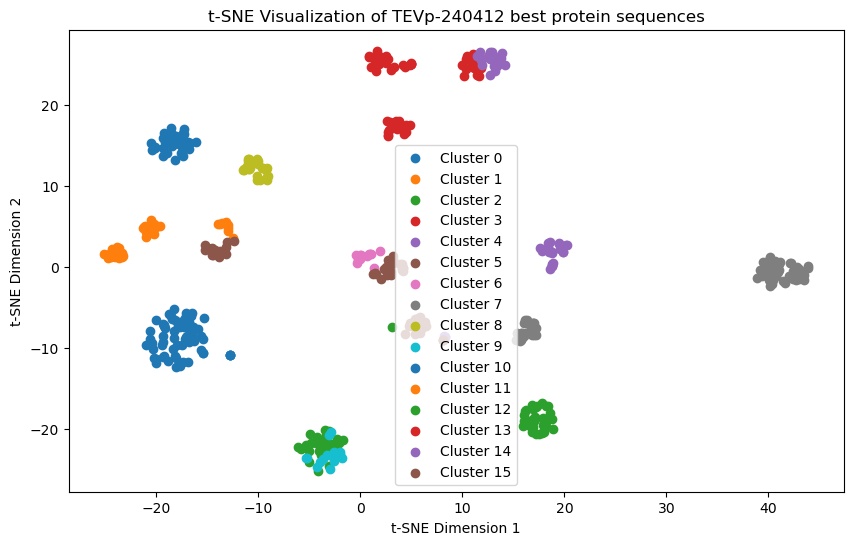

Cluster 0: 70 sequences
Scaffold Names: lcb3_30, lcb3_14
Cluster 1: 8 sequences
Scaffold Names: lcb3_25
Cluster 2: 30 sequences
Scaffold Names: lcb3_2
Cluster 3: 47 sequences
Scaffold Names: lcb3_9, lcb3_17
Cluster 4: 29 sequences
Scaffold Names: lcb3_27, lcb3_10
Cluster 5: 17 sequences
Scaffold Names: lcb3_25
Cluster 6: 13 sequences
Scaffold Names: lcb3_16
Cluster 7: 67 sequences
Scaffold Names: lcb3_15, 2H3E_18
Cluster 8: 26 sequences
Scaffold Names: lcb3_7
Cluster 9: 17 sequences
Scaffold Names: lcb3_2
Cluster 10: 37 sequences
Scaffold Names: lcb3_22
Cluster 11: 31 sequences
Scaffold Names: lcb3_14, lcb3_6
Cluster 12: 38 sequences
Scaffold Names: 60_3Hs
Cluster 13: 14 sequences
Scaffold Names: lcb3_21
Cluster 14: 25 sequences
Scaffold Names: lcb3_21
Cluster 15: 47 sequences
Scaffold Names: lcb3_16, lcb3_10, lcb3_28, lcb3_8


TypeError: agg function failed [how->mean,dtype->object]

In [10]:
filtered["seq_split"] = filtered["seq"].apply(lambda x: x.split("/")[-1])

num_clusters=16

seqs=filtered["seq_split"].to_list()
#matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in seqs])
max_length = max(len(seq) for seq in seqs)
padded_seqs = [seq.ljust(max_length, 'N') for seq in seqs]
matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in padded_seqs])
clusterid, error, nfound = kcluster(matrix, nclusters=num_clusters)

# Apply t-SNE to the matrix to reduce the dimensionality and visualize the sequences.
tsne = TSNE(n_components=2, random_state=42)
embedded_matrix = tsne.fit_transform(matrix)

# Create a scatter plot of the embedded points and label them with cluster IDs.
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_points = embedded_matrix[clusterid == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title(f"t-SNE Visualization of {input} best protein sequences")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
#plt.savefig(f"output/{input}/filtered_sequences/tsne_binders.png")
plt.show()

# Add cluster id to dataframe
filtered["clusterid"]=clusterid
#filtered.to_csv(f"output/{input}/filtered_sequences/2_filtered_binders_clus.csv", index=False)

cluster_counts = Counter(filtered['clusterid'])

# Group the DataFrame by 'clusterid' and get unique scaffold names for each group
unique_scaffold_names = filtered.groupby('clusterid')['scaffold_name'].unique()

# Iterate over the groups and print both cluster counts and unique scaffold names
for cluster_id, scaffold_names in unique_scaffold_names.items():
    print(f"Cluster {cluster_id}: {cluster_counts[cluster_id]} sequences")
    print(f'Scaffold Names: {", ".join(scaffold_names)}')

# Calculate average cluster metrics
average_metrics_by_cluster = filtered.groupby('clusterid').mean()
#average_metrics_by_cluster.to_csv(f"output/{input}/filtered_sequences/2_cluster_average.csv", index=False)
average_metrics_by_cluster

# Output final dataframe and binders
Code below will create folders with best [12, 24, 48 ..] binders and metrics.
Make sure to change cluster ratios based on the results above!

In [ ]:
# Select number of final sequences and cluster ratios
total_numbers=[12, 24, 48]
#total_numbers=[10, 20, 40]
#cluster_ratios = [0.4, 0.3, 0.3]
#cluster_ratios = [0.3,0.1,0.2,0.1,0.2,0.2]
cluster_ratios = [0.33, 0.33, 0.33]

# Function to calculate the number of sequences for each cluster based on the given ratios
def calculate_sequences_ratios(total_sequences, cluster_ratios):
    cluster_sequences = {}
    total_ratio = sum(cluster_ratios)
    remaining_sequences = total_sequences

    for i, ratio in enumerate(cluster_ratios):
        if i == len(cluster_ratios) - 1:
            cluster_sequences[i] = remaining_sequences
        else:
            sequences_for_cluster = int(total_sequences * ratio / total_ratio)
            cluster_sequences[i] = sequences_for_cluster
            remaining_sequences -= sequences_for_cluster

    return cluster_sequences

In [ ]:
cluster_sequences = calculate_sequences_ratios(12, cluster_ratios)
cluster_sequences

In [ ]:

for total_sequences in total_numbers:
    # Calculate the number of sequences for each cluster
    cluster_sequences = calculate_sequences_ratios(total_sequences, cluster_ratios)
    print(f"Total Sequences: {total_sequences}")
    print(cluster_sequences)

    # Create a new dataframe with the final number of sequences for each cluster
    final_sequences = []
    for cluster_id, num_sequences in cluster_sequences.items():
        cluster_data = filtered[filtered['clusterid'] == cluster_id].iloc[:num_sequences]
        final_sequences.append(cluster_data)

    final_dataframe = pd.concat(final_sequences)

    # Save the dataframe to a CSV file
    binder_pdbs_path=f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/binder_{total_sequences}_pdbs"
    os.makedirs(binder_pdbs_path, exist_ok=True)
    filename = f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/final_binders_{total_sequences}.csv"
    final_dataframe.to_csv(filename, index=False)

    for _, row in final_dataframe.iterrows():
        pdb_path = row["model_path"]

        #filtered_binders_path=f"output/{input}/filtered_sequences/colab_rf_eval_2domain_and_binder/filtered_binders"s
        # Copy pdb in filtered folder
        #model_path=row["model_path"]
        #model_name=model_path.split("/")[-1]
        #pdb_path=f"{filtered_binders_path}/{model_name}"

        if os.path.exists(pdb_path) and os.path.isfile(pdb_path):
            pdb_filename = os.path.basename(pdb_path)
            destination_path = os.path.join(binder_pdbs_path, pdb_filename)
            shutil.copy(pdb_path, destination_path)
            #print(f"Copied {pdb_filename} to {destination_path}")
        else:
            print(f"File not found: {pdb_path}")

    print(f"DataFrame for {total_sequences} sequences saved to {filename}")

In [11]:
total_numbers = [18, 36, 54]

# Initialize an empty list to collect scaffold_filtered DataFrames


for total_sequences in total_numbers:
    scaffolds_len = len(filtered["scaffold_name"].unique())
    all_scaffold_filtered = []
    for scaffold in filtered["scaffold_name"].unique():
        scaffold_filtered = filtered[filtered["scaffold_name"] == scaffold]
        sequences_to_take = int(total_sequences / scaffolds_len + 0.5)
        scaffold_filtered = scaffold_filtered.head(sequences_to_take)
        print(f"Scaffold: {scaffold}, Sequences to take: {sequences_to_take}")
        
        # Append scaffold_filtered DataFrame to the list
        all_scaffold_filtered.append(scaffold_filtered)

    # Concatenate all scaffold_filtered DataFrames into final_dataframe
    final_dataframe = pd.concat(all_scaffold_filtered)

    binder_pdbs_path = f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/binder_{total_sequences}_pdbs"
    os.makedirs(binder_pdbs_path, exist_ok=True)
    filename = f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/final_binders_{total_sequences}.csv"
    final_dataframe.to_csv(filename, index=False)

    for _, row in final_dataframe.iterrows():
        pdb_path = row["model_path"]

        if os.path.exists(pdb_path) and os.path.isfile(pdb_path):
            pdb_filename = os.path.basename(pdb_path)
            destination_path = os.path.join(binder_pdbs_path, pdb_filename)
            shutil.copy(pdb_path, destination_path)
        else:
            print(f"File not found: {pdb_path}")

    print(f"DataFrame for {total_sequences} sequences saved to {filename}")

Scaffold: lcb3_30, Sequences to take: 1
Scaffold: lcb3_14, Sequences to take: 1
Scaffold: lcb3_16, Sequences to take: 1
Scaffold: lcb3_9, Sequences to take: 1
Scaffold: lcb3_21, Sequences to take: 1
Scaffold: 60_3Hs, Sequences to take: 1
Scaffold: lcb3_15, Sequences to take: 1
Scaffold: lcb3_27, Sequences to take: 1
Scaffold: lcb3_10, Sequences to take: 1
Scaffold: 2H3E_18, Sequences to take: 1
Scaffold: lcb3_7, Sequences to take: 1
Scaffold: lcb3_17, Sequences to take: 1
Scaffold: lcb3_2, Sequences to take: 1
Scaffold: lcb3_22, Sequences to take: 1
Scaffold: lcb3_25, Sequences to take: 1
Scaffold: lcb3_28, Sequences to take: 1
Scaffold: lcb3_6, Sequences to take: 1
Scaffold: lcb3_8, Sequences to take: 1
DataFrame for 18 sequences saved to output/TEVp-240412/filtered_sequences/final_results/binders_18/final_binders_18.csv
Scaffold: lcb3_30, Sequences to take: 2
Scaffold: lcb3_14, Sequences to take: 2
Scaffold: lcb3_16, Sequences to take: 2
Scaffold: lcb3_9, Sequences to take: 2
Scaffol

In [ ]:
filtered["scaffold_name"].unique()

### other scaffolds

In [ ]:
new_other_seq = pd.read_csv("/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/CD45/filtered_sequences/other/stats.csv", delimiter=";", header=1)
new_other_seq

In [ ]:
new_other_seq["seq_split"] = new_other_seq["seq"].apply(lambda x: x.split("/")[-1])

num_clusters=2

seqs=new_other_seq["seq_split"].to_list()

In [ ]:
new_other_seq["seq_split"]

In [ ]:
destination_path = "/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/CD45/filtered_sequences/batch1"
os.makedirs(destination_path, exist_ok=True)

# for i,row in new_other_seq.head(2).iterrows():
#     model_path=row["model_path"]
#     model_name=model_path.split("/")[-1]
#     new_model_path=f"{destination_path}/{model_name}"
#     shutil.copyfile(model_path, new_model_path)

new_other_seq.head(2).to_csv(f"{destination_path}/other.csv", index=False)